# redMaPPer vs UPenn-PhotDec

The goal of this notebook is to match the latest redMaPPer catalog of central galaxies to the UPenn-PhotDec photometric catalog.  See [this notebook](https://github.com/moustakas/siena-astrophysics/blob/master/research/upenn-photdec/upenn-photdec.ipynb) for an exploration of the UPenn-PhotDec catalog.

Below is a list of some of the most relevant redMaPPer papers:
* [Rykoff et al. 2012, *Robust Optical Richness Estimation with Reduced Scatter*](http://adsabs.harvard.edu/abs/2012ApJ...746..178R)
* [Saro et al. 2015, *Constraints on the richness-mass relation and the optical-SZE positional offset distribution for SZE-selected clusters*](http://adsabs.harvard.edu/abs/2015MNRAS.454.2305S)
* [Simet et al. 2017, *Weak lensing measurement of the mass-richness relation of SDSS redMaPPer clusters*](http://adsabs.harvard.edu/abs/2017MNRAS.466.3103S)
* [Melchior et al. 2017, *Weak-lensing mass calibration of redMaPPer galaxy clusters in Dark Energy Survey Science Verification data*](http://adsabs.harvard.edu/abs/2017MNRAS.469.4899M)


* [Rykoff et al. 2014, *redMaPPer. I. Algorithm and SDSS DR8 Catalog*](http://adsabs.harvard.edu/abs/2014ApJ...785..104R)
* [Rozo et al. 2014, *redMaPPer II: X-Ray and SZ Performance Benchmarks for the SDSS Catalog*](http://adsabs.harvard.edu/abs/2014ApJ...783...80R)
* [Rozo et al. 2015a, *redMaPPer - III. A detailed comparison of the Planck 2013 and SDSS DR8 redMaPPer cluster catalogues*](http://adsabs.harvard.edu/abs/2015MNRAS.450..592R)
* [Rozo et al. 2015b, *redMaPPer - IV. Photometric membership identification of red cluster galaxies with 1 per cent precision*](http://adsabs.harvard.edu/abs/2015MNRAS.453...38R)


* [Rykoff et al. 2016, *The RedMaPPer Galaxy Cluster Catalog From DES Science Verification Data*](http://adsabs.harvard.edu/abs/2016ApJS..224....1R)

### Imports--

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker

import fitsio
import astropy.units as u
from astropy.table import Table, hstack
from astropy.coordinates import SkyCoord

from corner import corner

In [2]:
plt.style.use('seaborn-talk')
%matplotlib inline

### Read the redMaPPer catalog and make some diagnostic plots.

In [3]:
def lambda2mhalo(richness, redshift, Saro=False):
    """
    Convert cluster richness, lambda, to halo mass, given various 
    calibrations.
    
      * Saro et al. 2015: Equation (7) and Table 2 gives M(500).
      * Melchior et al. 2017: Equation (51) and Table 4 gives M(200).
      * Simet et al. 2017: 
    
    Other SDSS-based calibrations: Li et al. 2016; Miyatake et al. 2016; 
    Farahi et al. 2016; Baxter et al. 2016.

    TODO: Return the variance!

    """
    if Saro:
        pass
    
    # Melchior et al. 2017 (default)
    logM0, Flam, Gz, lam0, z0 = 14.371, 1.12, 0.18, 30.0, 0.5
    Mhalo = 10**logM0 * (richness / lam0)**Flam * ( (1 + redshift) / (1 + z0) )**Gz
    
    return Mhalo

In [4]:
def read_redmapper(version='v6.3.1', verbose=False):
    """Read the redMaPPer catalog of central galaxies.
    
    """
    reddir = os.path.join(os.getenv('IM_DATA_DIR'), 'redmapper', version)
    redinfo = fitsio.FITS(os.path.join(reddir, 'dr8_run_redmapper_{}_lgt5_catalog.fit'.format(version)))
    if verbose:
        print(redinfo[1])

    red = Table(redinfo[1].read(upper=True))
    return red

In [5]:
red = read_redmapper(verbose=True)


  file: /Users/ioannis/research/data/redmapper/v6.3.1/dr8_run_redmapper_v6.3.1_lgt5_catalog.fit
  extension: 1
  type: BINARY_TBL
  rows: 396047
  column info:
    MEM_MATCH_ID        i4  
    RA                  f8  
    DEC                 f8  
    MODEL_MAG           f4  array[5]
    MODEL_MAGERR        f4  array[5]
    IMAG                f4  
    IMAG_ERR            f4  
    ZRED                f4  
    ZRED_E              f4  
    ZRED_CHISQ          f4  
    BCG_SPEC_Z          f4  
    Z_SPEC_INIT         f4  
    Z_INIT              f4  
    Z                   f4  
    LAMBDA_CHISQ        f4  
    LAMBDA_CHISQ_E      f4  
    LAMBDA_ZRED         f4  
    LAMBDA_ZRED_E       f4  
    R_LAMBDA            f4  
    SCALEVAL            f4  
    MASKFRAC            f4  
    C_LAMBDA            f4  array[4]
    C_LAMBDA_ERR        f4  array[4]
    MAG_LAMBDA_ERR      f4  array[5]
    CHISQ               f4  
    Z_LAMBDA            f4  
    Z_LAMBDA_E          f4  
    Z_LAMBDA_NIT

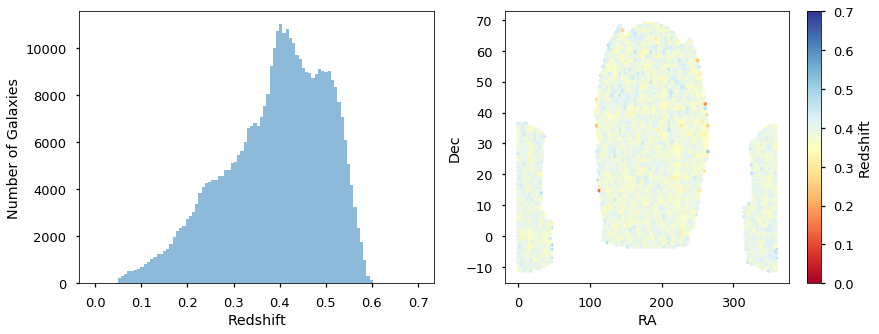

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
_, _, _ = ax1.hist(red['Z'], bins=100, range=(0, 0.7), alpha=0.5)
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Number of Galaxies')

hb = ax2.hexbin(red['RA'], red['DEC'], C=red['Z'], vmin=0, vmax=0.7,
                  cmap=plt.cm.get_cmap('RdYlBu'))
cb = plt.colorbar(hb)
cb.set_label('Redshift')
ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')

### Read the UPenn-PhotDec catalog and select a sample with good model fits in gri.

In [7]:
def photdec_select(finalflag, bit):
    """Select subsets of the catalog using the finalflag bitmask.

     1 - good bulge-only galaxy
     4 - good disk-only galaxy
    10 - good two-component fit (logical_or of flags 11, 12, and 13)
    20 - bad total magnitude and size

    """
    return finalflag & np.power(2, bit) != 0

In [8]:
def select_goodmodels(modelcat, onecomp=False, twocomp=False):
    """Select various galaxies with good model fits.
    
    Args:
      modelcat: 'UPenn_PhotDec_Models_[g,r,i]band.fits' catalog.
      onecomp (bool): galaxies fitted with single-Sersic model.
      twocomp (bool): galaxies fitted with Sersic-exponential model.
    
    Notes:
      * Flag 10 is a logical_or of 11, 12, 13.
      * Flag 1, 4, and 10 are mutually exclusive.
      * If Flag 1 or 4 are set then n_disk,r_disk are -999.
    
    """
    finalflag = modelcat['finalflag']
    smalln = modelcat['n_bulge'] < 8

    two = photdec_select(finalflag, 10)
    two = np.logical_and( two, smalln )
    if twocomp:
        return two

    one = np.logical_or( photdec_select(finalflag, 1), photdec_select(finalflag, 4) )
    one = np.logical_and( one, smalln )
    if onecomp:
        return one

    both = np.logical_or( one, two )
    
    return both

In [9]:
def _get_goodmodels_indices(basicdir, verbose=False):
    """Get the indices of galaxies with good model fits in all 
    three bands.
    
    """
    good = None
    for thisband in ('gband', 'rband', 'iband'):
        measurefile = os.path.join(basicdir, 'UPenn_PhotDec_nonParam_{}.fits'.format(thisband))
        modelsfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))

        measureinfo = fitsio.FITS(measurefile)
        modelsinfo = fitsio.FITS(modelsfile)    
    
        _models = Table(modelsinfo[1].read(columns=['finalflag', 'n_bulge']))
        _good = select_goodmodels(_models)
        if good is None:
            good = _good
            if verbose:
                print(measureinfo[1])
                print(modelsinfo[1])
            else:
                good = np.logical_and(good, _good)
                
    goodindx = np.where(good)[0]
    if verbose:
        print('Selected {}/{} galaxies with good model fits in gri.'.format(len(goodindx), len(_models)))
        
    return goodindx

In [10]:
def read_mendel(adddir, indx=None, verbose=False):
    """Read the UPenn-PhotDec stellar mass catalog based on the M/L ratios published
    by Mendel et al. 2014 (who used the Chabrier IMF).
    
    Note that papers by the UPenn group tend to prefer the dust-free M/L values 
    from Mendel et al. (their Table 5 instead of their Table 3); see Bernardi et al. 
    2017 for details and use 'Mstar_Tab5_Pymorph'.
    
    """
    mendelfile = os.path.join(adddir, 'UPenn_PhotDec_Mstar_mlMendel14.dat')
    columns = ('GalCount', 'FlagSerExp', 
               'Mstar_Tab5_Pymorph', 'Mstar_Tab5_Truncated', 
               'Mstar_Tab3_Pymorph', 'Mstar_Tab3_Truncated', 
               'Mstar_Tab5_Mendel', 'Mstar_Tab3_Mendel', 
               'Mstar_Tab5_cModel', 'Mstar_Tab3_cModel')
    columns = [cc.upper() for cc in columns]
    mendel = Table.read(mendelfile, format='ascii.no_header', names=columns)
    if indx is not None:
        mendel = mendel[indx]
    if verbose:
        print(mendel)
        
    return mendel

In [11]:
def read_upenn_photdec(version='v2', verbose=False):
    """Read all the UPenn-PhotDec catalogs of interest (in all three bands), 
    restricted to just the subset of galaxies with "good" model fits.
    
    """
    photdecdir = os.path.join(os.getenv('IM_DATA_DIR'), 'upenn-photdec')
    basicdir = os.path.join(photdecdir, 'basic-catalog', version)
    adddir = os.path.join(photdecdir, 'additional-catalogs')
    
    # First get the indices of galaxies with good model fits in gri.
    goodindx = _get_goodmodels_indices(basicdir, verbose=verbose)
    
    # Now read all the basic catalogs of interest.
    models, measure = [], []
    for thisband in ('gband', 'rband', 'iband'):
        modelsfile = os.path.join(basicdir, 'UPenn_PhotDec_Models_{}.fits'.format(thisband))
        measurefile = os.path.join(basicdir, 'UPenn_PhotDec_NonParam_{}.fits'.format(thisband))
        
        models.append(Table(fitsio.read(modelsfile, ext=1, rows=goodindx, upper=True)))
        measure.append(Table(fitsio.read(measurefile, ext=1, rows=goodindx, upper=True)))

    gmodels, rmodels, imodels = models
    gmeasure, rmeasure, imeasure = measure
    del models, measure
    
    # Read the CAST and CASTmodels catalogs.
    castfile = os.path.join(basicdir, 'UPenn_PhotDec_CAST.fits')
    castinfo = fitsio.FITS(castfile)
    if verbose:
        print(castinfo[1])
    cast = Table(castinfo[1].read(rows=goodindx, upper=True))
    
    castmodelsfile = os.path.join(adddir, 'UPenn_PhotDec_CASTmodels.fits')
    castmodelsinfo = fitsio.FITS(castmodelsfile)
    if verbose:
        print(castmodelsinfo[1])
        castmodels = Table(castmodelsinfo[1].read(rows=goodindx, upper=True))

    # Finally, read the Mendel-based stellar masses.
    mendel = read_mendel(adddir, indx=goodindx, verbose=verbose)
        
    return gmodels, rmodels, imodels, gmeasure, rmeasure, imeasure, cast, castmodels, mendel

In [12]:
gmodels, rmodels, imodels, gmeasure, rmeasure, imeasure, cast, castmodels, mendel = read_upenn_photdec(verbose=True)


  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_nonParam_gband.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    SexMag              f4  
    SexMag_Err          f4  
    SexHrad             f4  
    SexSky              f4  
    num_targets         i2  
    num_neighborfit     i2  
    AperRad             f4  
    C                   f4  
    C_err               f4  
    A                   f4  
    A_err               f4  
    S                   f4  
    S_err               f4  
    G                   f4  
    M20                 f4  
    extinction          f4  
    dismod              f4  
    kpc_per_arcsec      f4  
    Vmax                f4  
    SN                  f4  
    kcorr               f4  

  file: /Users/ioannis/research/data/upenn-photdec/basic-catalog/v2/UPenn_PhotDec_Models_gband.fits
  extension: 1
  type: BINARY_TBL
  rows: 670722
  column info:
    m_tot               f4  
    m_aper              f4  
 

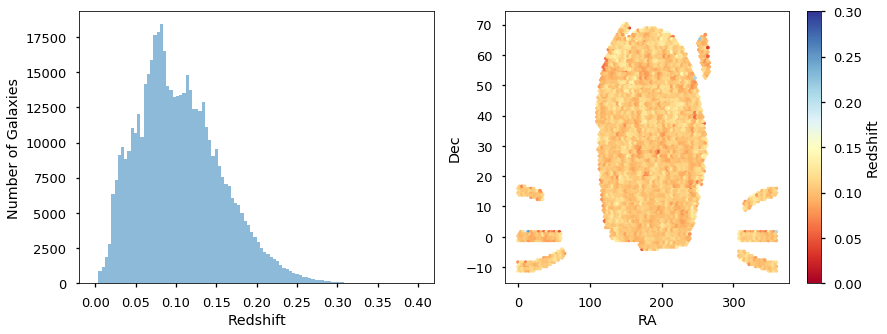

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
_, _, _ = ax1.hist(cast['Z'], bins=100, range=(0, 0.4), alpha=0.5)
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Number of Galaxies')

hb = ax2.hexbin(cast['RA'], cast['DEC'], C=cast['Z'], vmin=0, vmax=0.3,
                  cmap=plt.cm.get_cmap('RdYlBu'))
cb = plt.colorbar(hb)
cb.set_label('Redshift')
ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')

### Match, merge, and write out the two catalogs.

#### First look at the distribution of separations and then match using a 2 arcsec threshold.

In [14]:
redcoord = SkyCoord(ra=red['RA']*u.deg, dec=red['DEC']*u.deg)
castcoord = SkyCoord(ra=cast['RA']*u.deg, dec=cast['DEC']*u.deg)
_, sep2d, _ = castcoord.match_to_catalog_sky(redcoord)

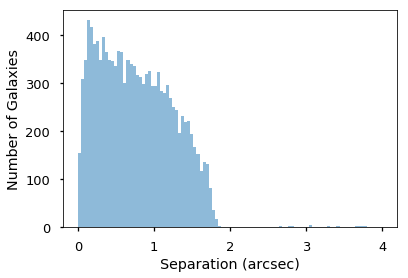

In [15]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(sep2d.arcsec, bins=100, range=(0, 4), alpha=0.5)
ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel('Number of Galaxies')

In [16]:
rad = 2.0 * u.arcsec
indx_red, indx_cast, d2d, _ = castcoord.search_around_sky(redcoord, rad)
nmatch = len(indx_red)
print('Found {} matches within {}'.format(nmatch, rad))

Found 12625 matches within 2.0 arcsec


In [17]:
redmatch = red[indx_red]
castmatch = cast[indx_cast]

#### Assume that the redMaPPer redshift is correct.

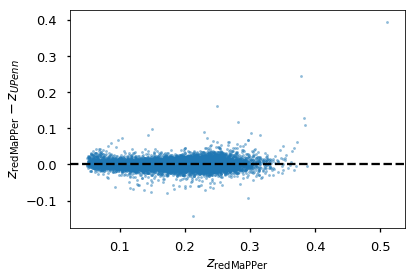

In [18]:
fig, ax = plt.subplots()
ax.scatter(redmatch['Z'], redmatch['Z'] - castmatch['Z'],
           s=5, alpha=0.5)
ax.set_xlabel(r'$z_{\rm redMaPPer}$')
ax.set_ylabel(r'$z_{\rm redMaPPer} - z_{UPenn}$')
ax.axhline(y=0.0, ls='--', color='k')

#### Merge the UPenn-PhotDec catalogs.

In [19]:
# gmodels, rmodels, imodels, gmeasure, rmeasure, imeasure, cast, castmodels, mendel
oldmodels = (gmodels[indx_cast], rmodels[indx_cast], imodels[indx_cast])
newmodels = []
for models, band in zip( oldmodels, ('G', 'R', 'I') ):
    oldcols = models.dtype.names
    for oldcol in oldcols:
        newcol = '{}_{}'.format(band, oldcol)
        models.rename_column(oldcol, newcol)
        newmodels.append(models)
outmodels = []
newmodels[0][:3]

G_M_TOT,G_M_APER,G_BT,G_R_TOT,G_BA_TOT,G_BT_APER,G_XCTR_BULGE,G_XCTR_BULGE_ERR,G_YCTR_BULGE,G_YCTR_BULGE_ERR,G_M_BULGE,G_M_BULGE_ERR,G_R_BULGE,G_R_BULGE_ERR,G_N_BULGE,G_N_BULGE_ERR,G_BA_BULGE,G_BA_BULGE_ERR,G_PA_BULGE,G_PA_BULGE_ERR,G_XCTR_DISK,G_XCTR_DISK_ERR,G_YCTR_DISK,G_YCTR_DISK_ERR,G_M_DISK,G_M_DISK_ERR,G_R_DISK,G_R_DISK_ERR,G_N_DISK,G_N_DISK_ERR,G_BA_DISK,G_BA_DISK_ERR,G_PA_DISK,G_PA_DISK_ERR,G_GALSKY,G_GALSKY_ERR,G_CHI2NU,G_FINALFLAG,G_AUTOFLAG,G_PYFLAG,G_PYFITFLAG
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32
15.2653,-999.0,0.38159,14.5187,0.597228,-999.0,213.13,0.01,286.4,0.01,16.3113,0.0272,4.17111,0.127433,2.429,0.0471,0.845,0.0042,66.9411,1.2652,215.11,0.67,284.22,0.36,15.7871,0.0174,33.8595,1.04743,1.0,-999.0,0.5404,0.0074,89.6039,0.8305,21.5273,0.000113257,1.05364,3073,0,62,2
16.9208,-999.0,0.341793,8.56172,0.772269,-999.0,263.26,0.05,263.38,0.05,18.0864,0.0915,3.05197,0.205603,1.4019,0.0689,0.9543,0.0101,0.6748,13.6963,264.47,0.42,261.11,0.52,17.3749,0.0321,15.4867,1.03727,1.0,-999.0,0.7665,0.018,30.4986,3.9524,22.1277,0.000102787,1.03814,5121,2048,62,1024
18.9256,-999.0,1.0,1.24165,0.673251,-999.0,78.97,0.04,79.63,0.03,18.9256,0.0274,1.54737,0.0636372,1.8286,0.1368,0.6724,0.0225,59.1842,2.7798,-999.0,-999.0,-999.0,-999.0,999.0,-999.0,-395.604,-395.604,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,22.0431,0.000636469,1.10117,81,2056,42,0


#### Write out.

In [20]:
outred
redmatched.write()

NameError: name 'outred' is not defined

### Estimate the halo mass of each group.

In [ ]:
mhalo = np.log10( lambda2mhalo(redmatch['LAMBDA_CHISQ'], redmatch['Z']) )

### Build some QAplots.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

_, _, _ = ax1.hist(redmatch['Z'], bins=100, range=(0, 0.4), alpha=0.5)
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Number of Galaxies')

_, _, _ = ax2.hist(redmatch['LAMBDA_CHISQ'], bins=100, alpha=0.5)
ax2.set_xlabel('Group Richness')
ax2.set_ylabel('Number of Galaxies')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
ax1.scatter(redmatch['Z'], redmatch['LAMBDA_CHISQ'], s=3, alpha=0.5)
ax1.set_yscale('log')
ax1.set_ylabel('Richness')
ax1.axhline(y=5.0, ls='--', color='k', lw=2)
ax1.axvline(x=0.05, ls='--', color='k', lw=2)

ax2.scatter(redmatch['Z'], mhalo, s=3, alpha=0.5)
ax2.set_ylabel(r'$\log_{10}\, (M_{200}\, /\, M_{\odot})$')
ax2.set_xlabel('Redshift')
ax2.axvline(x=0.05, ls='--', color='k', lw=2)

fig.subplots_adjust(hspace=0.05)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(mhalo, mendel['MSTAR_TAB5_PYMORPH'][indx_cast], 
           s=3, alpha=0.5)
ax.set_ylim(10, 13)
ax.set_xlabel(r'$\log_{10}\, (M_{200}\, /\, M_{\odot})$')
ax.set_ylabel(r'$\log_{10}\, (M_{*}\, /\, M_{\odot})$')
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))